Setup & Imports
You'll need to log into huggingface and accept the terms of the licence for this model - see the model card for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [16]:
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
!pip install -q --upgrade transformers diffusers ftfy

In [18]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
! mkdir "/root/.huggingface"

mkdir: cannot create directory ‘/root/.huggingface’: File exists


In [20]:
! cp "drive/MyDrive/.huggingface/token" /root/.huggingface/token

In [21]:
from base64 import b64encode

import numpy
import os
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# To the GPU we go!
vae = vae.to(torch_device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


The Autoencoder (AE)
The AE can 'encode' an image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [23]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [24]:
data_path = '/content/drive/MyDrive/expa/mini_mini_imagenet_data/mini_mini_imagenet'

In [25]:
%ls /content/drive/MyDrive/expa/mini_mini_imagenet_data/


mini_mini_imagenet/


In [26]:
# generate index
import numpy as np
import faiss
import pickle

In [47]:
index = faiss.IndexFlatL2(16384)

In [48]:
id_index = faiss.IndexIDMap(index)

In [49]:
test_ids, index_ids = {}, {}

In [50]:
index = 0
for file_name in os.listdir(data_path):
    file_path = os.path.join(data_path, file_name)
    try:
        # Open the image file with PIL
        # print(file_path)
        img = Image.open(file_path)
        # print(img.format)
        if img.format in ("JPEG","JPG") and img.mode == "RGB":
          # img.show()
          # encoded = torch.flatten(pil_to_latent(img.resize((512, 512))))
          # print(encoded.shape)
          if index % 10 == 0:
            test_ids[index] = file_name
          else:
            index_ids[index] = file_name
            encoded = pil_to_latent(img.resize((512, 512))).reshape(1, -1)
            # print(encoded.shape)
            # index.add(encoded.cpu())
            id_index.add_with_ids(encoded.cpu(), np.array(index))
          index += 1
    except IOError:
        print(f"Error opening file: {file_path}")
        continue

In [51]:
faiss.write_index(id_index, '/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index.index')


In [52]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_test_ids.pkl', 'wb') as f:
  pickle.dump(test_ids, f)

In [53]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index_ids.pkl', 'wb') as f:
  pickle.dump(index_ids, f)

In [54]:
id_index = faiss.read_index('/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index.index')


In [55]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_test_ids.pkl', 'rb') as f:
  test_ids = pickle.load(f)

In [56]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index_ids.pkl', 'rb') as f:
  index_ids = pickle.load(f)

In [57]:
len(test_ids)

976

In [66]:
len(index_ids)

8778

In [58]:
test_ids

{0: 'n02443484_9191.JPEG',
 10: 'n02966193_41482.JPEG',
 20: 'n02747177_27716.JPEG',
 30: 'n04596742_4211.JPEG',
 40: 'n04296562_27640.JPEG',
 50: 'n02747177_27827.JPEG',
 60: 'n04596742_29015.JPEG',
 70: 'n01843383_5928.JPEG',
 80: 'n04596742_32778.JPEG',
 90: 'n01843383_6061.JPEG',
 100: 'n02443484_11967.JPEG',
 110: 'n04596742_3197.JPEG',
 120: 'n02443484_14163.JPEG',
 130: 'n01843383_3857.JPEG',
 140: 'n04296562_35084.JPEG',
 150: 'n02443484_3181.JPEG',
 160: 'n02443484_1302.JPEG',
 170: 'n04296562_18059.JPEG',
 180: 'n01843383_6960.JPEG',
 190: 'n02747177_22138.JPEG',
 200: 'n04596742_23006.JPEG',
 210: 'n02747177_21929.JPEG',
 220: 'n02747177_23333.JPEG',
 230: 'n01843383_5693.JPEG',
 240: 'n04296562_20540.JPEG',
 250: 'n01843383_5768.JPEG',
 260: 'n04296562_54927.JPEG',
 270: 'n04596742_10.JPEG',
 280: 'n04515003_37225.JPEG',
 290: 'n02110063_7327.JPEG',
 300: 'n04389033_2014.JPEG',
 310: 'n04389033_2557.JPEG',
 320: 'n04515003_6110.JPEG',
 330: 'n02871525_13181.JPEG',
 340: 'n0

In [85]:
test_img = test_ids[90]
print(test_img)

n01843383_6061.JPEG


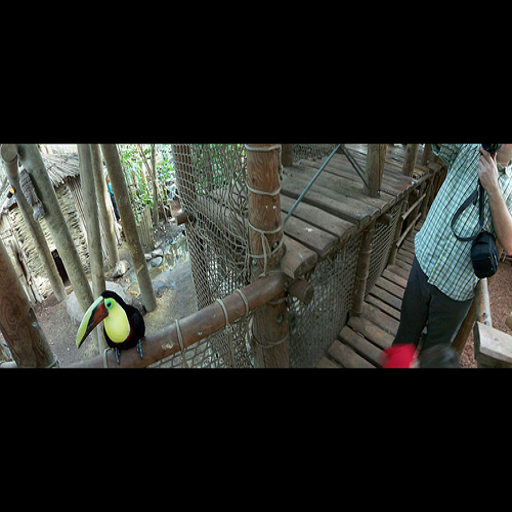

In [86]:
img = Image.open(os.path.join(data_path, str(test_img))).resize((512, 512))
img.show()

In [87]:
encoded = pil_to_latent(img).reshape(1, -1)

In [88]:
encoded.shape


torch.Size([1, 16384])

In [89]:
# Query the index for the k most similar encodings to a given query encoding
k = 30
distances, indices = id_index.search(encoded.cpu(), k)


In [90]:
print(indices)

[[8888 7844 5651 7733 9251 7581 1278 5782 2818 7579 3049 7738 2174 2646
  7486 4126 7401 8262 2572 3259 3117 4368 6271  183 9494 8584 8654 4936
  4076  837]]


In [91]:
print(distances)

[[13670.122 13893.549 15282.267 15292.268 15432.437 15612.207 15780.128
  15841.112 15855.107 15881.496 16195.641 16349.281 16453.783 16520.98
  16527.992 16808.04  16982.05  17076.178 17114.674 17256.723 17317.656
  17444.719 17479.738 17505.793 17575.516 17633.457 17763.139 17773.762
  17849.54  17895.271]]


n02795169_17911.JPEG


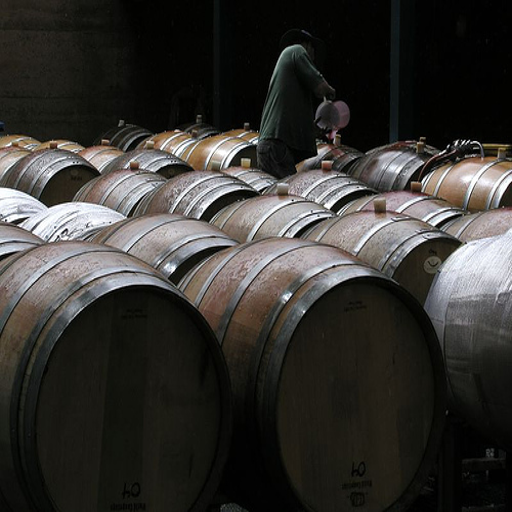

In [93]:
match_img = index_ids[indices[0][0]]
print(match_img)
img = Image.open(os.path.join(data_path, match_img)).resize((512, 512))
img

n04418357_7025.JPEG


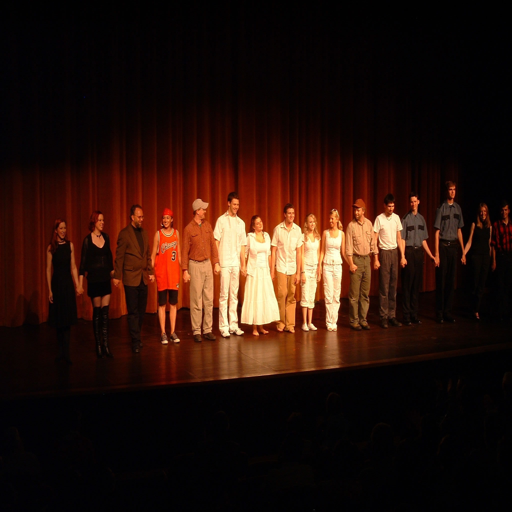

In [94]:
match_img = index_ids[indices[0][1]]
print(match_img)
img = Image.open(os.path.join(data_path, match_img)).resize((512, 512))
img

n06794110_1002.JPEG


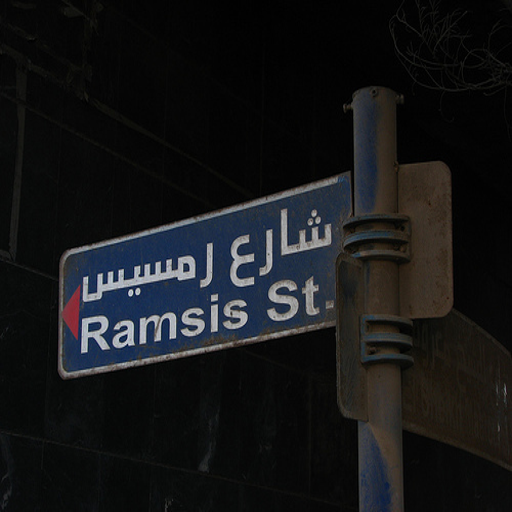

In [95]:
match_img = index_ids[indices[0][2]]
print(match_img)
img = Image.open(os.path.join(data_path, match_img)).resize((512, 512))
img